# The Fresh White Bread Index
## Final Project -- CMPUT 191

Group Members:
Tomas Tang (xt3),
Haley Lacza (lacza),
Simon Cudmore (scudmore)

In [2]:
import numpy as np
from datascience import *
import requests
from bs4 import BeautifulSoup
import pandas as pd
from IPython.core.display import display, HTML
from scipy.stats import pearsonr

# These lines set up graphing capabilities.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
def display_table(table):
  display(HTML(str(table)))
# step 1 - scrape fresh white bread pricing data
url = "https://www.numbeo.com/cost-of-living/prices_by_country.jsp?itemId=9&displayCurrency=CAD"
r = requests.get(url)

r.text
soup = BeautifulSoup(r.text, 'html.parser')
soup

table = soup.find('table', {"id":"t2"})


In [4]:
# step 2 - tidy up fresh white bread pricing data from scrape
def scrape_table(table):
    df = pd.read_html(str(table))
    df = pd.DataFrame(df[0])
    return Table.from_df(df)

final = scrape_table(table)
final2 = final.sort('Loaf of Fresh White Bread (500g)', descending=True)
clean = final2.take(np.arange(10)) #choose top 10 countries' data

clean

Rank,Country,Loaf of Fresh White Bread (500g)
nan,Switzerland,5.15
nan,United States,5.06
nan,Denmark,4.43
nan,Costa Rica,4.28
nan,Norway,4.24
nan,South Korea,4.19
nan,Luxembourg,4.16
nan,Austria,3.82
nan,Canada,3.7
nan,Sweden,3.69


### Taxes: Numbeo collects data with included sales taxes like GST and VAT, so no action rerquired to satisfy step 3 requirment. (https://www.numbeo.com/common/motivation_and_methodology.jsp#:~:text=Taxes,to%20estimate%20local%20purchasing%20power.)


In [5]:
# step 3 - scrape CurrencyScoop country codes
currency_url = "https://currencyscoop.com/supported-currencies"
currency_request = requests.get(currency_url)
currency_soup = BeautifulSoup(currency_request.text, 'html.parser')
currency_table = currency_soup.find("table")
currency_codes = scrape_table(currency_table)

### Exchange Rates Data Collected on 2024/11/29

In [6]:
# step 4 - display the currencies for each country
data = [["Switzerland", 5.16],["United States", 5.05],["Denmark", 4.44],["Costa Rica", 4.28],
    ["Norway", 4.27],["South Korea", 4.19],["Luxembourg", 4.13],["Austria", 3.81],["Canada", 3.69],["Sweden", 3.68],]

clean = pd.DataFrame(data, columns=["Country", "Loaf of Fresh White Bread (500g)"])

# Exchange rate data
exchange_rates = {"Switzerland": {"rate": 1.59, "symbol": "CHF"},"United States": {"rate": 1.40, "symbol": "USD"},
                  "Denmark": {"rate": 0.20, "symbol": "DKK"},"Costa Rica": {"rate": 0.0028, "symbol": "CRC"},
    "Norway": {"rate": 0.13, "symbol": "NOK"},"South Korea": {"rate": 0.0010, "symbol": "KRW"},"Luxembourg": {"rate": 1.48, "symbol": "EUR"},"Austria": {"rate": 1.48, "symbol": "EUR"},
                  "Canada": {"rate": 1.00, "symbol": "CAD"},"Sweden": {"rate": 0.13, "symbol": "SEK"},}

# Calculate local prices without symbols
clean["Local Price"] = clean.apply(
    lambda row: round(row["Loaf of Fresh White Bread (500g)"] / exchange_rates[row["Country"]]["rate"], 2),axis=1)

# Add Currency Code
clean["Code"] = clean["Country"].apply(lambda x: exchange_rates[x]["symbol"])
final_clean = clean[["Country", "Local Price", "Code"]]

final_clean


,Country,Local Price,Code
0,Switzerland,3.25,CHF
1,United States,3.61,USD
2,Denmark,22.20,DKK
3,Costa Rica,1528.57,CRC
4,Norway,32.85,NOK
5,South Korea,4190.00,KRW
6,Luxembourg,2.79,EUR
7,Austria,2.57,EUR
8,Canada,3.69,CAD
9,Sweden,28.31,SEK


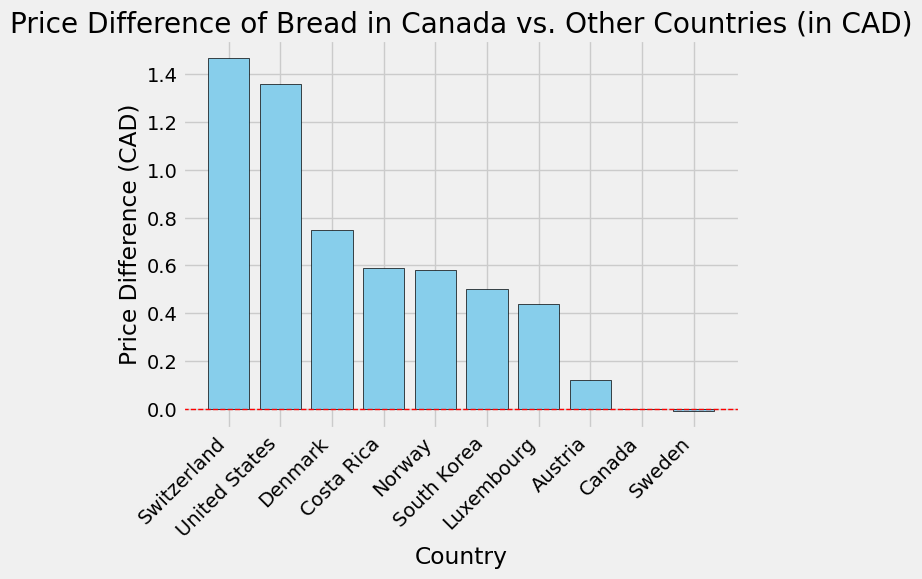

In [9]:
# step 5 - Displaying a bar chart of the white bread price difference between the price in Canada and other countries in CAD.
import matplotlib.pyplot as plt
# import data
data = [[ "Switzerland", 5.16], [ "United States", 5.05],[ "Denmark", 4.44], [ "Costa Rica", 4.28],[ "Norway", 4.27],
    ["South Korea", 4.19],["Luxembourg", 4.13],[ "Austria", 3.81],[ "Canada", 3.69],[ "Sweden", 3.68],]

clean = pd.DataFrame(data, columns=["Country", "Loaf of Fresh White Bread (500g)"])
canadian_price = clean.loc[clean["Country"] == "Canada", "Loaf of Fresh White Bread (500g)"].values[0]
clean["Price Difference"] = clean["Loaf of Fresh White Bread (500g)"] - canadian_price

clean
# Plot bar chart
plt.bar(clean["Country"], clean["Price Difference"], color="skyblue", edgecolor="black")
plt.axhline(0, color="red", linewidth=1, linestyle="--")  # Horizontal line at 0

plt.title("Price Difference of Bread in Canada vs. Other Countries (in CAD)")
plt.xlabel("Country")
plt.ylabel("Price Difference (CAD)")
plt.xticks(rotation=45, ha="right")
plt.show()


In [10]:
# step 6 - Importing data on an external factor
url = "https://www.indexmundi.com/agriculture/?commodity=wheat&graph=imports"
r = requests.get(url)

r.text
soup = BeautifulSoup(r.text, 'html.parser')
soup

table = soup.find('table', {"id":"horizontal-bar-chart"})
imports = scrape_table(table)
imports = imports.drop('Imports (1000 MT).1')

# Convert datascience Table to Pandas DataFrame
df = imports.to_df()

df.columns = df.columns.str.strip()
df = df.drop(columns=['Imports (1000 MT).1'], errors='ignore')

# List the selected countries
target_countries = ["Switzerland", "United States", "Denmark", "Costa Rica",
    "Norway", "Korea, Republic Of", "Luxembourg", "Austria", "Canada", "Sweden"]

filtered_imports = df[df['Country'].isin(target_countries)]
filtered_imports

,Rank,Country,Imports (1000 MT)
15,16,"Korea, Republic Of",4300
19,20,United States,3674
60,61,Canada,600
63,64,Switzerland,550
84,85,Costa Rica,310
86,87,Norway,300


### Since the dataset above only reports on the total of EU imports, we need more data for the specific EU countries.


Denmark: 0.01084; https://wits.worldbank.org/trade/comtrade/en/country/DNK/year/2023/tradeflow/Imports/partner/ALL/product/110900

Luxembourg:0.000552; https://wits.worldbank.org/trade/comtrade/en/country/All/year/2023/tradeflow/Exports/partner/LUX/product/110311

Austria: 0.0264; https://wits.worldbank.org/trade/comtrade/en/country/All/year/2023/tradeflow/Imports/partner/AUT/product/110311

Sweden :0.00487; https://wits.worldbank.org/trade/comtrade/en/country/SWE/year/2023/tradeflow/Imports/partner/ALL/product/110900

In [16]:
# step 7 - Import more data from website
data = {"Country": ["United States", "Canada", "Switzerland", "Costa Rica", "Norway", "South Korea"],
    "Imports (1000 MT)": [3674, 600, 550, 310, 300, 4300],}

# Additional data
new_data = {"Country": ["Denmark", "Luxembourg", "Austria", "Sweden"],
            "Imports (1000 MT)": [10.84, 0.552, 26.4, 4.87],}
new_df = pd.DataFrame(new_data)

# Append the new data to dataframe
final_model = pd.concat([df, new_df], ignore_index=True)
final_model


,Country,Imports (1000 MT)
0,United States,3674.000
1,Canada,600.000
2,Switzerland,550.000
3,Costa Rica,310.000
4,Norway,300.000
5,South Korea,4300.000
6,Denmark,10.840
7,Luxembourg,0.552
8,Austria,26.400
9,Sweden,4.870


In [17]:
# step 8 - Make column names are clean
final_clean.columns = final_clean.columns.str.strip()
final_model.columns = final_model.columns.str.strip()

# Check both DataFrames have the same columns
if "Country" not in final_clean.columns:
    final_clean.reset_index(inplace=True)
if "Country" not in final_model.columns:
    final_model.reset_index(inplace=True)

# Set "Country" as the index for both DataFrames
final_clean.set_index("Country", inplace=True)
final_model.set_index("Country", inplace=True)
Final_model = final_clean.join(final_model)

# Reset the index
Final_model.reset_index(inplace=True)
Final_model


,Country,Local Price,Code,Imports (1000 MT)
0,Switzerland,3.25,CHF,550.000
1,United States,3.61,USD,3674.000
2,Denmark,22.20,DKK,10.840
3,Costa Rica,1528.57,CRC,310.000
4,Norway,32.85,NOK,300.000
5,South Korea,4190.00,KRW,4300.000
6,Luxembourg,2.79,EUR,0.552
7,Austria,2.57,EUR,26.400
8,Canada,3.69,CAD,600.000
9,Sweden,28.31,SEK,4.870


In [18]:
# step 9 - Review the price difference table
data = [[ "Switzerland", 5.16], [ "United States", 5.05],[ "Denmark", 4.44], [ "Costa Rica", 4.28],[ "Norway", 4.27],
    ["South Korea", 4.19],["Luxembourg", 4.13],[ "Austria", 3.81],[ "Canada", 3.69],[ "Sweden", 3.68],]

clean = pd.DataFrame(data, columns=["Country", "Loaf of Fresh White Bread (500g)"])
canadian_price = clean.loc[clean["Country"] == "Canada", "Loaf of Fresh White Bread (500g)"].values[0]
clean["Price Difference"] = clean["Loaf of Fresh White Bread (500g)"] - canadian_price

clean

# Drop "Price Difference" column if it exists to prevent duplicates
if "Price Difference" in Final_model.columns: Final_model = Final_model.drop(columns=["Price Difference"])

# Merge the "Price Difference" column from `clean` into `Final_model2`
Final_model2 = Final_model.merge(clean[["Country", "Price Difference"]], on="Country", how="left")

# Display the updated Final_model2
Final_model2




,Country,Local Price,Code,Imports (1000 MT),Price Difference
0,Switzerland,3.25,CHF,550.000,1.47
1,United States,3.61,USD,3674.000,1.36
2,Denmark,22.20,DKK,10.840,0.75
3,Costa Rica,1528.57,CRC,310.000,0.59
4,Norway,32.85,NOK,300.000,0.58
5,South Korea,4190.00,KRW,4300.000,0.50
6,Luxembourg,2.79,EUR,0.552,0.44
7,Austria,2.57,EUR,26.400,0.12
8,Canada,3.69,CAD,600.000,0.00
9,Sweden,28.31,SEK,4.870,-0.01


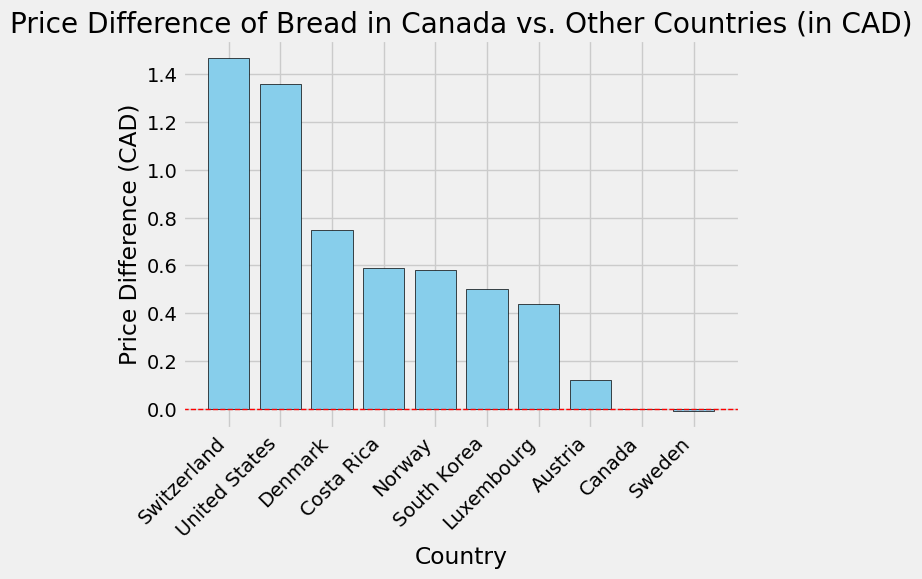

In [19]:
# step 10 - Review the price difference plot
import matplotlib.pyplot as plt
#import data
data = [[ "Switzerland", 5.16], [ "United States", 5.05],[ "Denmark", 4.44], [ "Costa Rica", 4.28],[ "Norway", 4.27],
    ["South Korea", 4.19],["Luxembourg", 4.13],[ "Austria", 3.81],[ "Canada", 3.69],[ "Sweden", 3.68],]

clean = pd.DataFrame(data, columns=["Country", "Loaf of Fresh White Bread (500g)"])
canadian_price = clean.loc[clean["Country"] == "Canada", "Loaf of Fresh White Bread (500g)"].values[0]
clean["Price Difference"] = clean["Loaf of Fresh White Bread (500g)"] - canadian_price
clean

# plot the table
plt.bar(clean["Country"], clean["Price Difference"], color="skyblue", edgecolor="black")
plt.axhline(0, color="red", linewidth=1, linestyle="--")  # Horizontal line at 0

plt.title("Price Difference of Bread in Canada vs. Other Countries (in CAD)")
plt.xlabel("Country")
plt.ylabel("Price Difference (CAD)")
plt.xticks(rotation=45, ha="right")
plt.show()

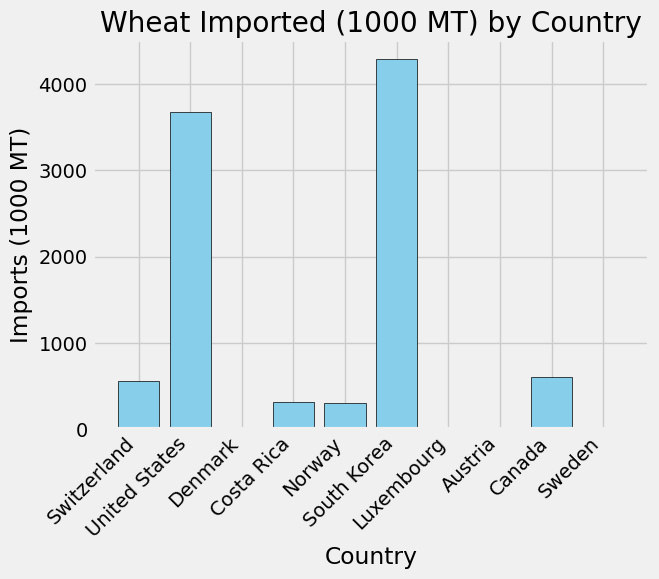

In [20]:
# step 11 - Plot Imports (1000 MT) as a bar chart
plt.bar(Final_model["Country"], Final_model["Imports (1000 MT)"], color="skyblue", edgecolor="black")
plt.axhline(0, color="red", linewidth=1, linestyle="--")  # Horizontal line at 0

# Add title and labels
plt.title("Wheat Imported (1000 MT) by Country")
plt.xlabel("Country")
plt.ylabel("Imports (1000 MT)")
plt.xticks(rotation=45, ha="right")

plt.show()


In [21]:
# Review the datatable
Final_model2

,Country,Local Price,Code,Imports (1000 MT),Price Difference
0,Switzerland,3.25,CHF,550.000,1.47
1,United States,3.61,USD,3674.000,1.36
2,Denmark,22.20,DKK,10.840,0.75
3,Costa Rica,1528.57,CRC,310.000,0.59
4,Norway,32.85,NOK,300.000,0.58
5,South Korea,4190.00,KRW,4300.000,0.50
6,Luxembourg,2.79,EUR,0.552,0.44
7,Austria,2.57,EUR,26.400,0.12
8,Canada,3.69,CAD,600.000,0.00
9,Sweden,28.31,SEK,4.870,-0.01


In [22]:
# step 12 - current wheat price in USD taken from https://markets.businessinsider.com/commodities/wheat-price?op=1 at 8:52pm 2024/11/29
currentwheatprice = 209.50

#USD exchange rates taken from https://www.exchange-rates.org/current-rates/usd at 9:00pm 2024/11/29
swiss = 0.88118
unitedstates = 1
Denmark = 0.945
Norway = 11.043
Costa = 508.52
Korea = 1395.5
Luxembourg = 0.945
Austria = 0.945
Canada = 1.402
Sweden = 10.903

countries = np.array(['Switzerland','United States','Denmark','Norway','Costa Rica','South Korea','Luxembourg','Austria','Canada','Sweden'])
exchangeratesUSD = np.array([swiss, unitedstates, Denmark,Norway,Costa,Korea,Luxembourg,Austria,Canada,Sweden])

#add countries and associated exchange rates to a table
USD = Table().with_columns('Country', countries,'Exchage Rate (USD to Other)', exchangeratesUSD)
USD


Country,Exchage Rate (USD to Other)
Switzerland,0.88118
United States,1
Denmark,0.945
Norway,11.043
Costa Rica,508.52
South Korea,1395.5
Luxembourg,0.945
Austria,0.945
Canada,1.402
Sweden,10.903


Country,Exchage Rate (Other to CAD),Exchage Rate (USD to Other),Loaf of Fresh White Bread (500g),Price Difference,Local Price,Code,Imports (1000 MT),Price Difference_2,Price of Wheat(CAD/MT),Import Costs (CAD/1000 MT)
Austria,1.393,0.945,3.81,0.12,2.57,EUR,26.4,0.12,275.783,7.28066e+06
Canada,1,1.402,3.69,0,3.69,CAD,600,0,293.719,1.76231e+08
Costa Rica,0.00274639,508.52,4.28,0.59,1528.57,CRC,310,0.59,292.587,9.07019e+07
Denmark,1.393,0.945,4.44,0.75,22.2,DKK,10.84,0.75,275.783,2.98948e+06
Luxembourg,1.393,0.945,4.13,0.44,2.79,EUR,0.552,0.44,275.783,152232
Norway,0.1546,11.043,4.27,0.58,32.85,NOK,300,0.58,357.668,1.07301e+08
South Korea,0.001111,1395.5,4.19,0.5,4190,KRW,4300,0.5,324.809,1.39668e+09
Sweden,0.146,10.903,3.68,-0.01,28.31,SEK,4.87,-0.01,333.49,1.6241e+06
Switzerland,1.3005,0.88118,5.16,1.47,3.25,CHF,550,1.47,240.082,1.32045e+08
United States,1.3315,1,5.05,1.36,3.61,USD,3674,1.36,278.949,1.02486e+09


Text(0.5, 0, 'Import Costs(CAD)')

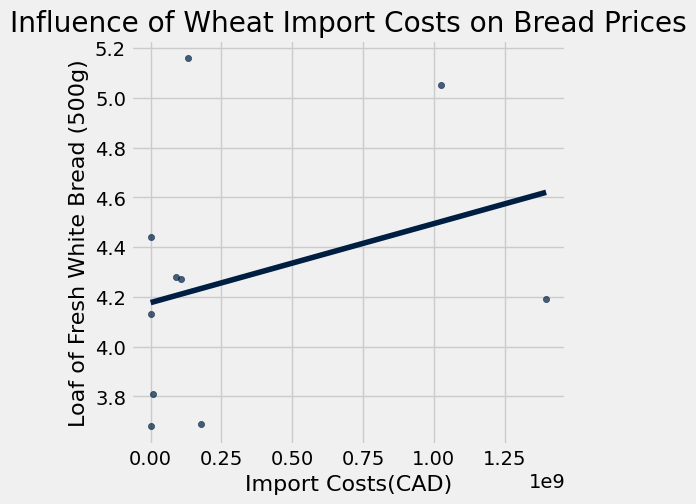

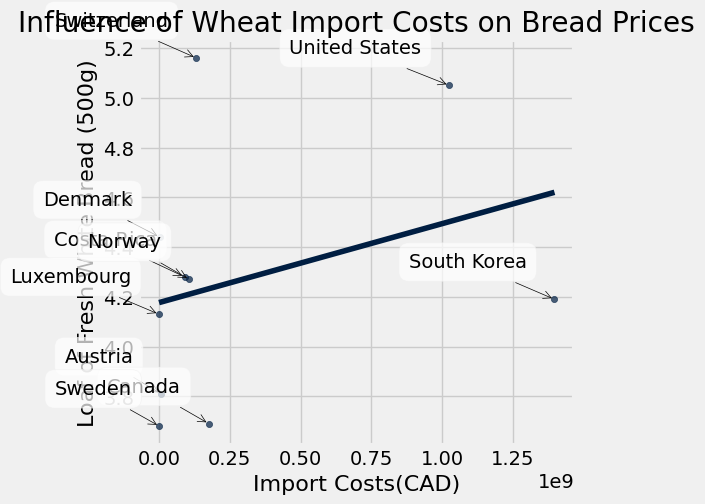

In [23]:
# step 13 - exchange rates of currencies to CAD collected from the Bank of Canada at 10:13pm 2024/11/29
CAD = Table().with_columns('Country', countries,'Exchage Rate (Other to CAD)', np.array([1.3005,1.3315,1.393,0.1546,0.002746394,0.001111,1.393,1.393,1,0.146]))
CAD

#join the USD exchange rates and CAD exchange rates to the final model 2 dataframe
cleantable = Table().from_df(Final_model2)
othercleantable = Table().from_df(clean)
withexchanges = Table.join(CAD, 'Country', USD, 'Country')
everything = Table.join(withexchanges, 'Country', othercleantable, 'Country')
alldata = Table.join(everything, 'Country', cleantable, 'Country')

#converting price of wheat(USD) to price of wheat in local currencies
wheatother = alldata.column('Exchage Rate (USD to Other)')*currentwheatprice

#converting the local currencies to CAD
standardwheatprice = wheatother*alldata.column('Exchage Rate (Other to CAD)')

#adding a column to the table with price of wheat in CAD for each country
alldata = alldata.with_column('Price of Wheat(CAD/MT)', standardwheatprice)

#multiplying the cost of wheat in each country by the amount of wheat they import
alldata = alldata.with_column('Import Costs (CAD/1000 MT)', (alldata.column('Price of Wheat(CAD/MT)')*alldata.column('Imports (1000 MT)')*1000))

#displaying updated table with Importation Costs
alldata.show()

#displaying a scatter plot of wheat import costs per country by cost of bread to see if this is a factor influencing bread prices
alldata.scatter('Import Costs (CAD/1000 MT)', 'Loaf of Fresh White Bread (500g)', fit_line=True)
plots.title('Influence of Wheat Import Costs on Bread Prices')
plots.xlabel('Import Costs(CAD)')

#displaying a second plot with labels to see where the countries lie
alldata.scatter('Import Costs (CAD/1000 MT)', 'Loaf of Fresh White Bread (500g)', labels='Country', fit_line=True)
plots.title('Influence of Wheat Import Costs on Bread Prices')
plots.xlabel('Import Costs(CAD)')



In [24]:
# step 14 - Find the correlation and p value
import_costs = alldata.column('Import Costs (CAD/1000 MT)')
bread_prices = alldata.column('Loaf of Fresh White Bread (500g)')

# Calculating the correlation coefficient
correlation, p_value = pearsonr(import_costs, bread_prices)

# Displaying the correlation coefficient and p-value
correlation, p_value


(0.30742248745418699, 0.38754623150898238)